### 决策树
- 决策树构造
- 在数据集中度量一致性
- 使用递归构造决策树
---

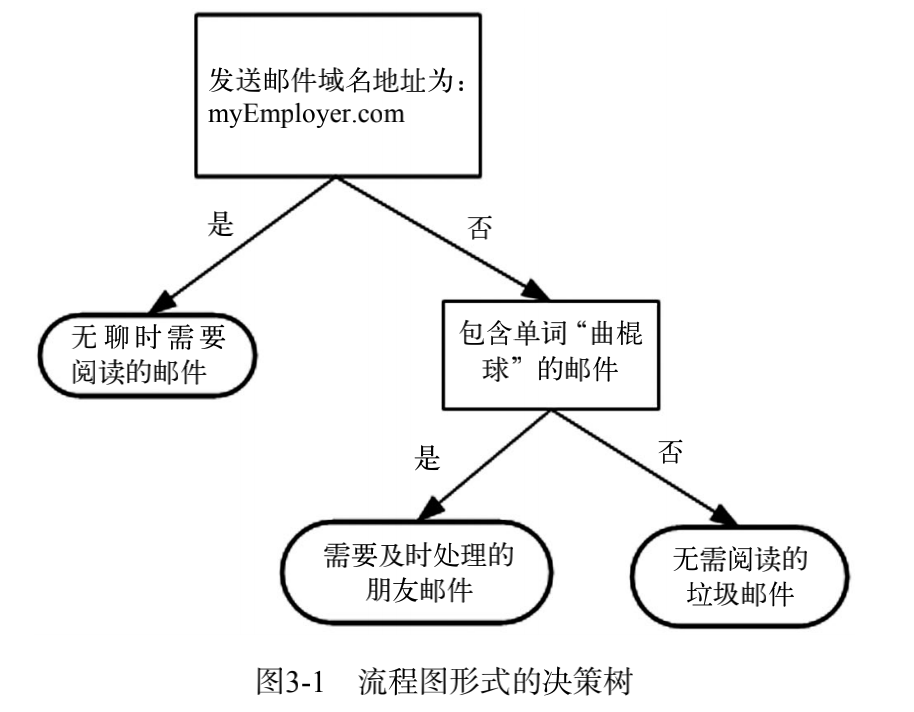

#### 1.决策树的构造
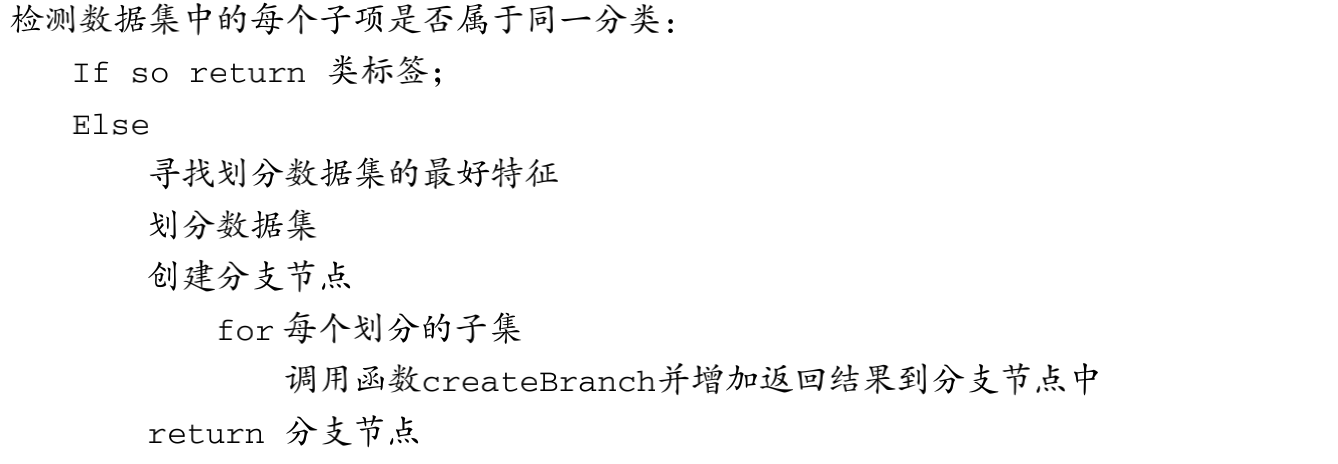
##### 信息增益

In [3]:
"""
file_name:trees.py
function:calculate entropy of a given dataset
"""
from math import log

def calcShannonEnt(dataset):
    numEntries = len(dataset)
    # 为所有可能的分类创建字典
    labelCount = {}
    for item in dataset:
        label = item[-1]
        if label not in labelCount.keys():
            labelCount[label] = 0
        labelCount[label] += 1
    shannonEntro = 0.0
    for key in labelCount:
        p = labelCount[key] / numEntries
        shannonEntro -= p*log(p,2)
    return shannonEntro

In [4]:
# 测试数据
def createDataSet():
    dataset = [
        [1,1,'yes'],
        [1,1,'yes'],
        [1,0,'no'],
        [0,1,'no'],
        [0,1,'no']
    ]
    features = ['no surfacing', 'flippers']
    return dataset, features

In [5]:
myData, features = createDataSet()
calcShannonEnt(myData)

0.9709505944546686

In [6]:
# 观察熵的变化
myData[0][-1] = 'maybe'
myData

[[1, 1, 'maybe'], [1, 1, 'yes'], [1, 0, 'no'], [0, 1, 'no'], [0, 1, 'no']]

In [7]:
calcShannonEnt(myData)

1.3709505944546687

In [8]:
"""
function:split dataset
input:划分数据集，划分特征，特征值
"""
def splitDataSet(dataset,feature,value):
    resDataSet = []
    for item in dataset:
        if item[feature] == value:
            reducedItem = item[:feature]
            reducedItem.extend(item[feature+1:])
            resDataSet.append(reducedItem)
    return resDataSet

In [9]:
myData[0][-1] = 'yes'
myData

[[1, 1, 'yes'], [1, 1, 'yes'], [1, 0, 'no'], [0, 1, 'no'], [0, 1, 'no']]

In [10]:
splitDataSet(myData,0,1)

[[1, 'yes'], [1, 'yes'], [0, 'no']]

In [11]:
splitDataSet(myData,0,0)

[[1, 'no'], [1, 'no']]

In [23]:
splitDataSet(myData,1,0)

[[1, 'no']]

In [24]:
splitDataSet(myData,1,1)

[[1, 'yes'], [1, 'yes'], [0, 'no'], [0, 'no']]

In [46]:
"""
function:选择最好的特征（循环计算每个特征的信息增益，选择增益最大的特征）
input:数据集
output:选取的最好划分特征
"""
def chooseBestFeature(dataSet):
    # 特征数量（去掉了label列）
    numsFeature = len(dataSet[0]) - 1
    # 1.计算原始信息熵
    baseEntropy = calcShannonEnt(dataSet)
    bestInfoGain = 0.0
    bestFeature = -1
    # 2.循环选取最好的特征
    for i in range(numsFeature):
        featureList = [ sample[i] for sample in dataSet]
        # 确定特征所有可能的取值
        features = set(featureList)
        newEntropy = 0.0
        for value in features:
            subDataSet = splitDataSet(dataSet,i,value)
            proportion = len(subDataSet) / len(dataSet)
            p = calcShannonEnt(subDataSet)
            newEntropy += proportion * p
        entropyGain = baseEntropy - newEntropy
#         print(i,entropyGain)
        if entropyGain > bestInfoGain:
            bestInfoGain = entropyGain
            bestFeature = i
    return bestFeature        

In [22]:
chooseBestFeature(myData)

0 0.4199730940219749
1 0.17095059445466854


0

##### 递归构造决策树

**原理说明**：
- 利用原始数据集，选择最好的特征进行划分，得到若干个子集合
- 对子集合进行递归划分
- 递归出口：
    - 无特征可以进一步划分，此时选择子集中样本数最多的种类作为子集标签
    - 子集合样本的类别一致

In [30]:
"""
function:选择数据集中样本数最多的分类名称
input：类别列表
output：样本数最多的类别名称
"""
import operator
def classSelector(classList):
    classDic = {}
    for item in classList:
        if item not in classDic.keys():
            classDic[item] = 0
        classDic[item] += 1
    sortedClassCount = sorted(classDic.items(),key=operator.itemgetter(1),reverse=True)
    # 排序后为元组列表：(key,value)
    return sortedClassCount[0][0]

**python的字典树**<br/>
形如：
```python
Tree = {"a": "$",
        "b": {
            "c":
                {"g": "$", "h": "$"},
            "e":
                {"i": "$", "j": "$"},
            "f":
                {"k": "$", "l": "$"},
        }}
```

In [54]:
"""
function:构建决策树
input:数据集，特征标签（['no surfacing','flippers'])
output:决策树
"""
def createTree(dataSet,featureList):
    # 递归出口：
    classList = [ item[-1] for item in dataSet]
    classSet = set(classList)
    # 1）全部属于同一类
    if len(classSet) == 1:
        return classList[0]
    # 2）无特征可划分
    if len(featureList) == 0:
        return classSelector(classList)
    # 1.递归主体
    # 1.1 选择最好的特征
    bestFeatureIndex = chooseBestFeature(dataSet)
    bestFeatureValue = featureList[bestFeatureIndex]
    myTree = {bestFeatureValue:{}}
    # 删除已选择的特征
    del(featureList[bestFeatureIndex])
    # 1.2 根据特征划分子集合
    featureValuesList = [ item[bestFeatureIndex] for item in dataSet]
    featureValues = set(featureValuesList)
    for value in featureValues:
        # 必须进行切片式传递才不是引用传递
        subFeatureList = featureList[:]
        # 参数传递列表时用引用方式传递，为防止子函数破坏特征列表，需要重新创建
        # 变量传递特征列表
        subDataSet = splitDataSet(dataSet,bestFeatureIndex,value)
        myTree[bestFeatureValue][value] = createTree(subDataSet,\
                                                     subFeatureList)
   
    return myTree

In [57]:
# 生成数据集
myData, features = createDataSet()
features

['no surfacing', 'flippers']

In [59]:
# 测试
featureList = features[:] # 注意使用切片
myTree = createTree(myData,featureList)
myTree

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}

##### 测试和存储分类器
使用决策树构建分类器，存储分类器，在测试数据上使用决策树分类算法

In [63]:
"""
function:使用决策树进行分类决策
input:构建的决策树，待分类数据
output:数据对应的标签
分类数据格式:[1,0]
标签顺序：['no surfacing','flippers']
"""
def classify(inputTree,testVector,featureList):
    # 第一个分类的特征名称
    firstFeatureValue = list(inputTree.keys())[0]
    # 后续分类使用的树
    subTree = inputTree[firstFeatureValue]
    # 对应特征值
    feature = testVector[featureList.index(firstFeatureValue)]
    # 特征值分类
    if type(subTree[feature]).__name__ == 'dict':
        classLabel = classify(subTree[feature],testVector,featureList)
    else:
        classLabel = subTree[feature]
    return classLabel

In [65]:
# 测试
myData,features = createDataSet()
featureList = features[:]
myTree = createTree(myData,featureList)
print(myTree)
print(classify(myTree,[1,1],features))

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}
yes


In [68]:
"""
function:存储得到的决策树模型
    需要使用Python模块pickle序列化对象，序列化对象可以在磁盘上保存对象，
    并在需要的时候读取出来。任何对象都可以执行序列化操作
"""
import pickle
def storeTree(inputTree,filename):
    fw = open(filename,'wb')
    pickle.dump(inputTree,fw)
    fw.close

def readTree(filename):
    fr = open(filename,'rb')
    return pickle.load(fr)

In [69]:
storeTree(myTree,'classifierTestTree_fish.txt')
readTree('classifierTestTree_fish.txt')

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}